<a href="https://colab.research.google.com/github/Fathanhelmi/Twitter-scraping/blob/main/Crawling_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
pip install tweepy

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'


In [17]:
import tweepy
import pandas as pd
# import gspread
import os

In [18]:
# Replace with your actual credentials
consumer_key = "tZQ1jHRcYulD1mbi0AFWMK8xh"
consumer_secret = "7GfSi6z1U4KUBeQulIzAOfxhSe8KbWCqQVzXtZAIiAaCaDJIpo"
access_token = "1990377089577689089-vQ19gJfSfYggRpNytkDOFaZdjZx6Js"
access_token_secret = "g1eMInOw6Lj8RDfaBd53rx0Y7B1gQJfiZDgTjfm2qPlyI"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAFjo5QEAAAAAyRcl%2BqPmI1ZPs%2BduruLbAIk2VIk%3DDqXhb5vej9iNZIxafsywetHAceWp9orFZQSt8C9knQH7hmD4kX"

try:
    # Authenticate with the Twitter API
    auth = tweepy.OAuth1UserHandler(
        consumer_key,
        consumer_secret,
        access_token,
        access_token_secret,
        bearer_token
    )
    api = tweepy.API(auth)

    # Verify credentials (optional but recommended)
    api.verify_credentials()
    print("Authentication successful!")

except tweepy.TweepyException as e:
    print(f"Error during authentication: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Authentication successful!


In [19]:
import tweepy
import pandas as pd

# --- sudah ada di kamu ---
client = tweepy.Client(bearer_token)

search_query = "#MBG lang:id -is:retweet"

try:
    response = client.search_recent_tweets(
        query=search_query,
        max_results=100,
        tweet_fields=["created_at", "lang", "public_metrics"]
    )

    tweets = response.data

    if tweets:
        rows = []
        for tweet in tweets:
            rows.append({
                "tweet_id": tweet.id,
                "created_at": tweet.created_at,
                "lang": tweet.lang,
                "text": tweet.text,
                "retweet_count": tweet.public_metrics.get("retweet_count", 0),
                "reply_count": tweet.public_metrics.get("reply_count", 0),
                "like_count": tweet.public_metrics.get("like_count", 0),
                "quote_count": tweet.public_metrics.get("quote_count", 0),
            })

        df = pd.DataFrame(rows)
        print("Jumlah tweet:", len(df))
        print(df.head())
    else:
        print("Found 0 tweets.")
        df = pd.DataFrame()  # biar variabel df tetap ada

except tweepy.TweepyException as e:
    print(f"Error during tweet search: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Jumlah tweet: 100
              tweet_id                created_at lang  \
0  1990381521212158248 2025-11-17 11:28:28+00:00   in   
1  1990376847495086404 2025-11-17 11:09:54+00:00   in   
2  1990374221013533142 2025-11-17 10:59:28+00:00   in   
3  1990373668262916448 2025-11-17 10:57:16+00:00   in   
4  1990365316522942830 2025-11-17 10:24:05+00:00   in   

                                                text  retweet_count  \
0  #konteksnews Ga Terima Dikasih Masukan Soal MB...              0   
1  #MBG\nMakan Bergizi Gratis✖️\nMakan Bercangkan...              0   
2                      @8uP444 ＃MBG　＃cIuster　😭😭😭😭😭😭😭              0   
3  Sekretaris Desa Papa Garang, Ridwan, mengungka...              0   
4  Yayasan Kemala Bhayangkari Polres Abdya Luncur...              0   

   reply_count  like_count  quote_count  
0            1           0            0  
1            0           0            0  
2            0           1            0  
3            0           2            0  
4 

In [20]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL SENTIMEN MULTILINGUAL ROBERTA
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

id2label = {0: "negative", 1: "neutral", 2: "positive"}

def indo_roberta_sentiment(text, max_length=128):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral", 0.0

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    probs = softmax(logits, dim=1).cpu().numpy()[0]
    idx = probs.argmax()
    return id2label[idx], float(probs[idx])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [22]:
from tqdm.auto import tqdm

translated_texts = []
evaluations = []
probs = []

for text in tqdm(df["text"], desc="Analyse", position=0, leave=True):

    label, prob = indo_roberta_sentiment(text)
    evaluations.append(label)
    probs.append(prob)

df["Evaluation"] = evaluations
df["Prob"] = probs

if "created_at" in df.columns:
    df_final = df.sort_values("created_at").reset_index(drop=True)
else:
    df_final = df.reset_index(drop=True)

df_final = df_final[["created_at", "tweet_id", "text", "Evaluation", "Prob"]]
df_final.head(100)


Analyse:   0%|          | 0/100 [00:00<?, ?it/s]

,created_at,tweet_id,text,Evaluation,Prob
0,2025-11-17 00:00:54+00:00,1990208488610615399,MBG MAKANNN SAYANGGG\nmie ayam????\n#mbg https...,neutral,0.457216
1,2025-11-17 00:01:13+00:00,1990208566574375306,@kangdede78 Makan Bergizi Gratis (MBG) adalah ...,positive,0.624012
2,2025-11-17 00:02:49+00:00,1990208971857355046,@cutsarina5 Makan Bergizi Gratis (MBG) adalah ...,positive,0.622616
3,2025-11-17 00:04:32+00:00,1990209402000044527,@AntoniusCDN @Urrangawak @CakKhum @FirzaHusain...,positive,0.628404
4,2025-11-17 00:06:57+00:00,1990210012577517807,@03__nakula Makan Bergizi Gratis (MBG) adalah ...,positive,0.609044
...,...,...,...,...,...
95,2025-11-17 10:24:05+00:00,1990365316522942830,Yayasan Kemala Bhayangkari Polres Abdya Luncur...,neutral,0.606535
96,2025-11-17 10:57:16+00:00,1990373668262916448,"Sekretaris Desa Papa Garang, Ridwan, mengungka...",neutral,0.868619
97,2025-11-17 10:59:28+00:00,1990374221013533142,@8uP444 ＃MBG ＃cIuster 😭😭😭😭😭😭😭,negative,0.711585
98,2025-11-17 11:09:54+00:00,1990376847495086404,#MBG\nMakan Bergizi Gratis✖️\nMakan Bercangkan...,neutral,0.628812


In [23]:
df["Evaluation"].value_counts()

,count
Evaluation,
positive,51
neutral,43
negative,6


In [24]:
pip install wordcloud

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'


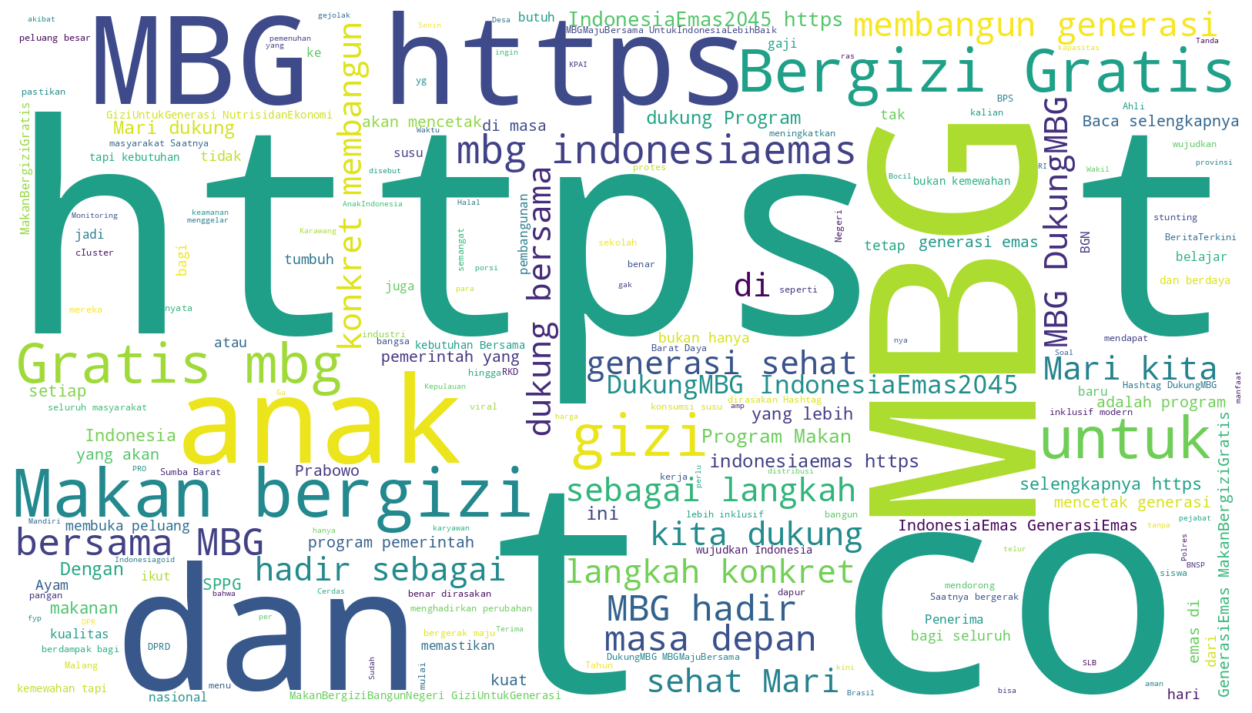

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df["text"].astype(str).tolist())

wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    colormap="viridis"
).generate(all_text)

plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:

df_to_txt = df_final[["created_at", "tweet_id", "text", "Evaluation", "Prob"]]

# Nama file
filename = "Crawling MBG_X.txt"

# Tulis ke file .txt
with open(filename, "w", encoding="utf-8") as f:
    f.write("Tweet Analysis Output\n")
    f.write("=======================================\n\n")

    for idx, row in df_to_txt.iterrows():
        f.write(f"Row {idx+1}\n")
        f.write(f"Date       : {row['created_at']}\n")
        f.write(f"Tweet ID   : {row['tweet_id']}\n")
        f.write(f"Text (ID)  : {row['text']}\n")
        f.write(f"Sentiment  : {row['Evaluation']}\n")
        f.write(f"Prob       : {row['Prob']}\n")
        f.write("---------------------------------------\n\n")

print(f"TXT saved as: {filename}")

TXT saved as: Crawling MBG_X.txt
